# Comparing Gradient Descent to LM

In [16]:
import scipy as sp
import scipy.optimize
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
from hashlib import sha256

from utils_fit import get_anchors_and_scores_mean_curve, convert_table2, remove_rows_with_nan_or_inf, load_from_parts, remove_bad_fits, failed_fits_statistics,  prepare_total_dataframe, plot_data2, plot_trn_data2, plot_prediction2, plot_prediction_smooth2, get_fun_model_id, get_XY2, get_ranks_from_tables, build_rank_table, convert_to_cd_tables, filter_table, prepare_data_for_cd, make_all_cd_plots, print_pretty_rank_table_transpose, plot_metric, get_relevant_max_anchor, empirical_cdf
from fit_database import fit_model, get_multiple_extrapolations_mean_curve_robust, df_compute_metrics_mean_curve


In [17]:
fn_metrics_GD = 'fitting_results_GD/metrics_example.gz'
fn_metrics_LM = 'fitting_results_LM/metrics_example.gz'
fn_metrics_BFGS = 'fitting_results_BFGS/metrics_example.gz'

if exists(fn_metrics_GD):
    metrics_GD = pd.read_pickle(fn_metrics_GD)
else:
    print("metrics for Gradient descent not yet calculated")
    
if exists(fn_metrics_LM):
    metrics_LM = pd.read_pickle(fn_metrics_LM)
else:
    print("metrics for LM not yet calculated") 
    
if exists(fn_metrics_BFGS):
    metrics_BFGS = pd.read_pickle(fn_metrics_BFGS)
else:
    print("metrics for BFGS not yet calculated")
    
metrics_BFGS    

,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,0.000055,0.001461,1.163626e-03,0.006107,0.036369,0.034112,256,0.098918,4,pow4
1,0.000075,0.000162,5.898005e-10,0.007042,0.008262,0.000024,362,0.139876,5,pow4
2,0.000062,0.000182,1.028251e-05,0.005922,0.011016,0.003207,1448,0.559505,6,pow4
3,0.000077,0.000200,1.998299e-04,0.007528,0.014136,0.014136,2048,0.791345,7,pow4
4,0.000055,0.001467,1.169581e-03,0.006105,0.036449,0.034199,256,0.098918,4,pow3
...,...,...,...,...,...,...,...,...,...,...
13131,0.000316,0.000205,2.916464e-07,0.013104,0.010400,0.000540,512,0.250000,5,expd3
13132,0.000320,0.000015,1.534028e-05,0.015422,0.003917,0.003917,1024,0.500000,6,expd3
13133,0.000324,0.000294,2.308989e-04,0.014566,0.015814,0.015195,256,0.125000,4,logpower3
13134,0.000298,0.000524,1.523970e-04,0.013544,0.021135,0.012345,512,0.250000,5,logpower3


In [12]:
LM_total = pd.read_pickle('fitting_results_LM/df_total.gz')
GD_total = pd.read_pickle('fitting_results_GD/df_total.gz')
BFGS_total = pd.read_pickle('fitting_results_BFGS/df_total.gz')

[LM_clean, LM_removed] = remove_bad_fits(LM_total)
[GD_clean, GD_removed] = remove_bad_fits(GD_total)
[BFGS_clean, BFGS_removed] = remove_bad_fits(BFGS_total)

fail due to init 0
fail due to fit 554
fail total 554
number of rows with nans / infs: 526
columns with nans / infs:
openmlid           False
learner            False
max_anchor_seen    False
fails_init         False
fails_fit          False
MSE_trn            False
MSE_tst             True
MSE_tst_last        True
dtype: bool
performance too bad for analysis:
MSE_trn             0
MSE_tst         26651
MSE_tst_last    34198
dtype: int64
number of offending rows:
34223
fail due to init 0
fail due to fit 554
fail total 554
number of rows with nans / infs: 526
columns with nans / infs:
openmlid           False
learner            False
max_anchor_seen    False
fails_init         False
fails_fit          False
MSE_trn            False
MSE_tst             True
MSE_tst_last        True
dtype: bool
performance too bad for analysis:
MSE_trn             0
MSE_tst         26651
MSE_tst_last    34198
dtype: int64
number of offending rows:
34223
fail due to init 0
fail due to fit 554
fail total 55

In [15]:
LM_model_performance = LM_clean.groupby(['curve_model'])['MSE_tst'].mean().reset_index()
BFGS_model_performance = BFGS_clean.groupby(['curve_model'])['MSE_tst'].mean().reset_index()
GD_model_performance = GD_clean.groupby(['curve_model'])['MSE_tst'].mean().reset_index()

# .groupby(['curve_model'])['MSE tst'].mean().reset_index()
print("Levenberg-Marquardt")
print(LM_model_performance)
print("BFGS")
print(BFGS_model_performance)
print("Gradient Descent")
print(GD_model_performance)

# plt.figure().set_figwidth(5)
# plt.barh(LM_model_performance['curve_model'], LM_model_performance['MSE_tst'])
# plt.show()

# plt.figure().set_figwidth(5)
# plt.barh(GD_model_performance['curve_model'], GD_model_performance['MSE_tst'])
# plt.show()

# plt.figure().set_figwidth(5)
# plt.barh(BFGS_model_performance['curve_model'], BFGS_model_performance['MSE_tst'])
# plt.show()


Levenberg-Marquardt
   curve_model   MSE_tst
0         exp2  0.835785
1         exp3  0.090969
2         exp4  0.094922
3        expd3  0.081411
4        expp3  0.049055
5        ilog2  0.005454
6        last1  0.005832
7         lin2  1.143454
8         log2  0.013330
9    logpower3  0.027976
10        mmf4  0.113522
11        pow2  0.078976
12        pow3  0.059501
13        pow4  0.130181
14        vap3  0.066651
15        wbl4  0.092318
BFGS
   curve_model   MSE_tst
0         exp2  0.835785
1         exp3  0.090969
2         exp4  0.094922
3        expd3  0.081411
4        expp3  0.049055
5        ilog2  0.005454
6        last1  0.005832
7         lin2  1.143454
8         log2  0.013330
9    logpower3  0.027976
10        mmf4  0.113522
11        pow2  0.078976
12        pow3  0.059501
13        pow4  0.130181
14        vap3  0.066651
15        wbl4  0.092318
Gradient Descent
   curve_model   MSE_tst
0         exp2  0.835785
1         exp3  0.090969
2         exp4  0.094922
3       

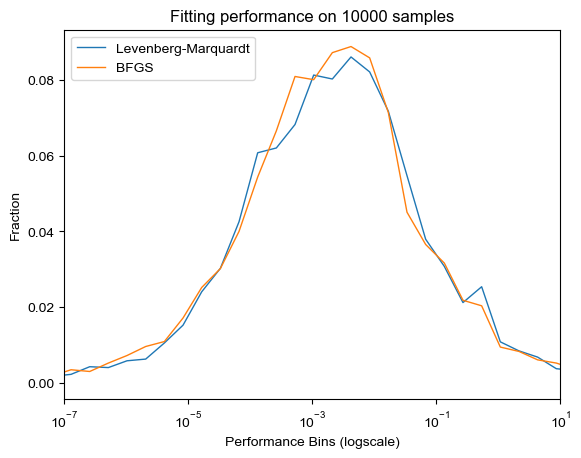

In [18]:
MSE_tst_LM = metrics_LM["MSE tst"]
#MSE_tst_GD = metrics_GD["MSE tst"]
MSE_tst_BFGS = metrics_BFGS["MSE tst"]

n = metrics_LM["MSE tst"].size

plot_metric(MSE_tst_LM,'Levenberg-Marquardt')
#plot_metric(MSE_tst_GD,'Gradient Descent')
plot_metric(MSE_tst_BFGS, 'BFGS')

plt.xlabel('Performance Bins (logscale)')
plt.ylabel('Fraction')
plt.legend()
plt.title('Fitting performance on 10000 samples')
plt.xlim([1e-7,1e1])
plt.show()

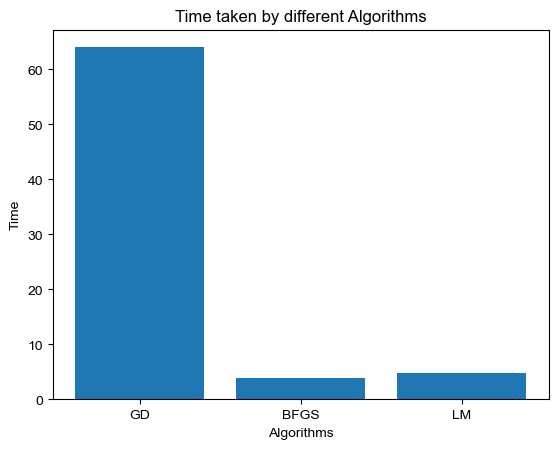

In [32]:
time_GD = 64
time_BFGS = 3.842233180999756
time_LM = 4.717349290847778

# Create a list of algorithms and corresponding time values
algorithms = ['GD', 'BFGS', 'LM']
times = [time_GD, time_BFGS, time_LM]

# Plotting histogram
plt.bar(algorithms, times)

# Adding labels and title
plt.xlabel('Algorithms')
plt.ylabel('Time')
plt.title('Time taken by different Algorithms')

# Display the histogram
plt.show()